In [ ]:
!pip install textattack pyarrow==1.0 bert_score

In [ ]:
import nlp
dataset = nlp.load_dataset('glue', 'qqp')
dataset['validation'][0]

{'idx': 0,
 'label': 0,
 'question1': 'Why are African-Americans so beautiful?',
 'question2': 'Why are hispanics so beautiful?'}

In [ ]:
test_data = dataset['validation']
print(len(test_data))
test_data[2]

40430


{'idx': 2,
 'label': 1,
 'question1': 'Is there a reason why we should travel alone?',
 'question2': 'What are some reasons to travel alone?'}

In [ ]:
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder

constraint = UniversalSentenceEncoder()

In [ ]:
import torch

def use_dist(s1, s2):
  emb1, emb2 = constraint.model([s1, s2])
  emb1, emb2 = torch.tensor(emb1.numpy()), torch.tensor(emb2.numpy())
  return torch.nn.CosineSimilarity(dim=0)(emb1, emb2).item()

print(use_dist('I love to eat chocolate', 'Chocolate is so good'))
print(use_dist('Turkey is a country, just like Chile', 'Alex Rodriguez takes steroids'))

0.7270165085792542
0.0411975271999836


In [ ]:
import bert_score
bert_scorer = bert_score.BERTScorer(
    model_type='bert-base-uncased', idf=False, device='cpu'
)

BERT_SCORE_TYPE2IDX = {"precision": 0, "recall": 1, "f1": 2}

def bert_score_dist(s1, s2):
  result = bert_scorer.score([s1], [s2])
  return result[BERT_SCORE_TYPE2IDX['f1']].item()


print(bert_score_dist('Are you having fun?', 'Are you fun having?'))
print(bert_score_dist('I love to eat chocolate', 'Chocolate is so good'))
print(bert_score_dist('Turkey is a country, just like Chile', 'Alex Rodriguez takes steroids'))

0.7307001352310181
0.5003132820129395
0.3376696705818176


In [ ]:
import tqdm

data_points = []
for j in tqdm.trange(1, min(len(test_data), 1001)):
  data_point = test_data[j]
  data_point['use_cos_sim'] = use_dist(data_point['question1'], data_point['question2'])
  data_point['bert_score'] = bert_score_dist(data_point['question1'], data_point['question2'])
  data_points.append(data_point)

100%|██████████| 1000/1000 [02:41<00:00,  6.19it/s]


In [ ]:
data_points[0]

{'bert_score': 0.4636758863925934,
 'idx': 1,
 'label': 0,
 'question1': 'I want to pursue PhD in Computer Science about social network,what is the open problem in social networks?',
 'question2': 'I handle social media for a non-profit. Should I start going to social media networking events? Are there any good ones in the bay area?',
 'use_cos_sim': 0.4282861053943634}

label
0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
1    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
dtype: object

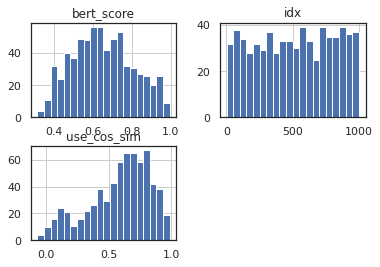

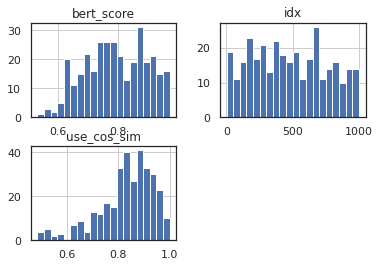

In [ ]:
import pandas as pd

df = pd.DataFrame(data_points)

df.groupby('label').hist(bins=20)

In [ ]:
import seaborn as sns
sns.set()

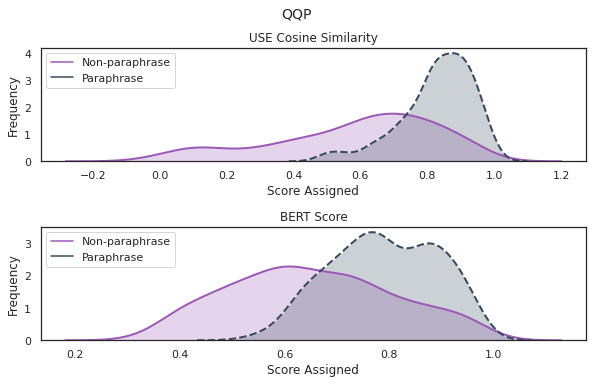

In [ ]:
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)

#######################################
####   Graph 1 - USE Similarity    ####
#######################################
sns.kdeplot(df[df['label'] == 0]['use_cos_sim'], label='Non-paraphrase', shade=True, ax=ax[0], color="#9b59b6")
ax[0] = sns.kdeplot(df[df['label'] == 1]['use_cos_sim'], label='Paraphrase', shade=True, ax=ax[0], color="#34495e")
ax[0].lines[0].set_linewidth(2)
ax[0].lines[1].set_linewidth(2)
ax[0].lines[1].set_linestyle("dashed")

ax[0].set_xlabel('Score Assigned')
ax[0].set_ylabel('Frequency')
ax[0].set_title('USE Cosine Similarity')

#######################################
####   Graph 2 - BERT Score        ####
#######################################
sns.kdeplot(df[df['label'] == 0]['bert_score'], label='Non-paraphrase', shade=True, ax=ax[1], color="#9b59b6")
sns.kdeplot(df[df['label'] == 1]['bert_score'], label='Paraphrase', shade=True, ax=ax[1], color="#34495e")
ax[1].lines[0].set_linewidth(2)
ax[1].lines[1].set_linewidth(2)
ax[1].lines[1].set_linestyle('dashed')

ax[1].set_xlabel('Score Assigned')
ax[1].set_ylabel('Frequency')
ax[1].set_title('BERT Score')

fig_size = plt.gcf().get_size_inches()
sizefactor = 1.4 # Zoom factor
plt.gcf().set_size_inches(sizefactor * fig_size) 

fig.suptitle('QQP', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Magic layout that takes into account subptitle
plt.savefig('qqp_constraint_distribution.pdf')

AUC for bert_score: 0.7636423853077817
AUC for use_cos_sim: 0.8268093060394889


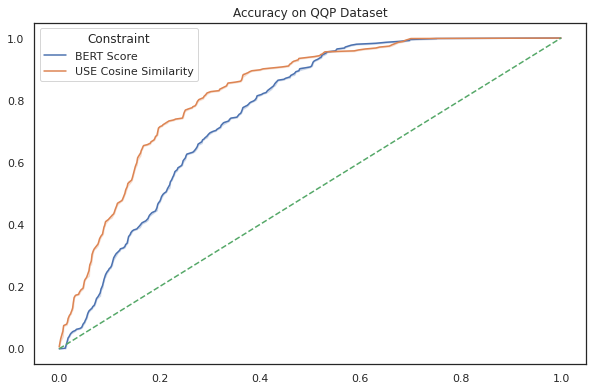

In [ ]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots()
def plot_roc(pred_key, ax=None, plot_reference_line=False):
  y = [float(x['label']) for x in data_points]
  preds = [x[pred_key] for x in data_points]
  fake_preds = [0] * len(y) # fake predictions for linear roc curve
  fpr, tpr, thresholds = roc_curve(y, preds)

  print(f'AUC for {pred_key}:', auc(fpr, tpr))
  fake_fpr, fake_tpr, fake_thresholds = roc_curve(y, fake_preds)

  sns.lineplot(fpr, tpr, ax=ax)#, title='ROC Curve')

  if plot_reference_line:
    plt_ax = sns.lineplot(fake_fpr, fake_tpr, ax=ax)#, title='ROC Curve')
    plt_ax.lines[-1].set_linestyle('dashed')
  # sns.kdeplot(df[df['label'] == '1']['bert_score'], label='Paraphrase', shade=True, ax=ax[1])


plot_roc('bert_score', ax=ax)
plot_roc('use_cos_sim', ax=ax, plot_reference_line=True)

plt.legend(title='Constraint', loc='best', labels=['BERT Score', 'USE Cosine Similarity', ])
plt.title('Accuracy on QQP Dataset')

fig_size = plt.gcf().get_size_inches()
sizefactor = 1.4 # Zoom factor
plt.gcf().set_size_inches(sizefactor * fig_size) 

fig.tight_layout()
plt.savefig('qqp_roc.pdf')